In [1]:
import h5py
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap']='jet'
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from MD_AE_tools.mode_decomposition import POD


import tensorflow as tf
tf.keras.backend.set_floatx('float32')
import configparser
import MD_AE_tools.ae_mode_evaluation as mode_eval
mse = tf.keras.losses.MeanSquaredError()
import MD_AE_tools.models.models_ff as modelff

from scipy import interpolate
from matplotlib import mlab
from tensorflow.keras.callbacks import ModelCheckpoint
# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
from MD_AE_tools.models import model_evaluation
from MD_AE_tools.ae_mode_evaluation import equivalent_pca_energy
from project_specific_utils import read_pressure
from project_specific_utils.read_pressure import PIVdata
from numpy import einsum
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=4096)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[2], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


In [2]:
which_sets = [PIVdata.PIV7, PIVdata.PIV9, PIVdata.PIV12, PIVdata.PIV17]

with h5py.File('./data/raw_pressure.h5','r') as hf:
    print(hf.keys())
    dt = np.squeeze(hf.get('dt'))
    static_p = np.squeeze(hf.get('static_p'))
    esp = np.array(hf.get('esp')).T
    r = np.array(hf.get('r')).T
    theta = np.array(hf.get('theta')).T


x=(np.cos(theta*np.pi/180).T)*r
y=(np.sin(theta*np.pi/180).T)*r 
x = x.flatten()
y = y.flatten()

## Parameters
nfft_psd = 1024
overlap = nfft_psd/2
# sampling_freq = 225
sampling_freq = 720
num_of_tests = len(which_sets)
D = 196.5 #mm
Uinf = 15 #m/s

esp_allt = np.concatenate(esp[which_sets,:,:],axis=1)
pmean = np.mean(esp_allt,axis=1).reshape(8,8)
prms = np.std(esp_allt,axis=1)
esp_allt.shape

<KeysViewHDF5 ['dt', 'esp', 'r', 'static_p', 'theta']>


(64, 10928)

(0.00427077636351069, -0.00011924686784118076)


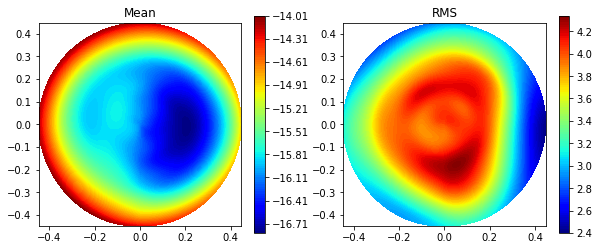

In [3]:
print(read_pressure.cop(pmean))
x_interp,y_interp,pmean_interp = read_pressure.interp(pmean,nint=15,filter=False)
_,_,prms_interp = read_pressure.interp(prms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,pmean_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('Mean')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('RMS')
plt.colorbar(im1,ax=ax2)

plt.show()

In [4]:
pod_data = POD(esp_allt)
modes,lam = pod_data.get_modes
a = pod_data.get_time_coefficient
_mean = np.mean(esp_allt,axis=1,keepdims=True)
reconstructed_pod = pod_data.reconstruct(5)
print(f'Reconstruct with 2 POD modes gives MSE {mse(reconstructed_pod-_mean,esp_allt-_mean)}')

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.
Returning temporal coefficients for classic POD.
Returning temporal coefficients for classic POD.
Reconstruct with 2 POD modes gives MSE 1.8412787914276123


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


In [5]:
rel_l2 = (np.sum((reconstructed_pod-_mean - (esp_allt-_mean))**2) / np.sum((esp_allt-_mean)**2))**0.5
print('relative error: ', rel_l2)

relative error:  0.36671258777442245


# Model
Model parameters

In [12]:
[n,nt] = esp_allt.shape

## ae configuration
lmb = 0.0000 #1e-05 #regulariser
drop_rate = 0.0
act_fct = 'tanh'
resize_meth = 'bilinear'
batch_norm = True

## feedforward ae configuration
input_shape = n
encoder_layers = [128,256,256,128,64]
decoder_layers = [64,128,256,256,128]


## training
nb_epoch = 3000
batch_size = 300
learning_rate = 0.004


p_train = esp_allt - pmean.flatten()[:,np.newaxis]
p_train = p_train.T

In [7]:
lrschedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    learning_rate,
    100,
    t_mul=50,
    m_mul=0.9
)

# AE

In [13]:
latent_dim = 5

ae = modelff.Autoencoder(
    input_shape = input_shape,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    latent_dim = latent_dim,
    act_fct = act_fct,
    batch_norm = batch_norm,
    drop_rate = drop_rate,
    lmb = lmb
)
ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64)]              0         
                                                                 
 encoder_1 (Encoder)         (None, 5)                 151104    
                                                                 
 decoder_1 (Decoder)         (None, 64)                151104    
                                                                 
Total params: 302,208
Trainable params: 298,880
Non-trainable params: 3,328
_________________________________________________________________


In [14]:
loss_ae = []

In [15]:
ae.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse')
# ae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
# ae.load_weights(tempfn_ae)

Epoch 1/1000
37/37 - 1s - loss: 0.1706 - 723ms/epoch - 20ms/step
Epoch 2/1000
37/37 - 1s - loss: 0.1778 - 653ms/epoch - 18ms/step
Epoch 3/1000
37/37 - 1s - loss: 0.1763 - 634ms/epoch - 17ms/step
Epoch 4/1000
37/37 - 1s - loss: 0.1616 - 732ms/epoch - 20ms/step
Epoch 5/1000
37/37 - 1s - loss: 0.1565 - 724ms/epoch - 20ms/step
Epoch 6/1000
37/37 - 1s - loss: 0.1773 - 661ms/epoch - 18ms/step
Epoch 7/1000
37/37 - 1s - loss: 0.1782 - 680ms/epoch - 18ms/step
Epoch 8/1000
37/37 - 1s - loss: 0.1920 - 683ms/epoch - 18ms/step
Epoch 9/1000
37/37 - 1s - loss: 0.1857 - 676ms/epoch - 18ms/step
Epoch 10/1000
37/37 - 1s - loss: 0.1678 - 686ms/epoch - 19ms/step
Epoch 11/1000
37/37 - 1s - loss: 0.1622 - 682ms/epoch - 18ms/step
Epoch 12/1000
37/37 - 1s - loss: 0.1777 - 680ms/epoch - 18ms/step
Epoch 13/1000
37/37 - 1s - loss: 0.1616 - 673ms/epoch - 18ms/step
Epoch 14/1000
37/37 - 1s - loss: 0.1717 - 681ms/epoch - 18ms/step
Epoch 15/1000
37/37 - 1s - loss: 0.1640 - 673ms/epoch - 18ms/step
Epoch 16/1000
37/37

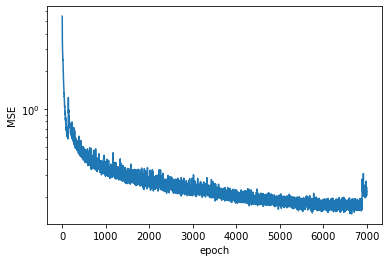

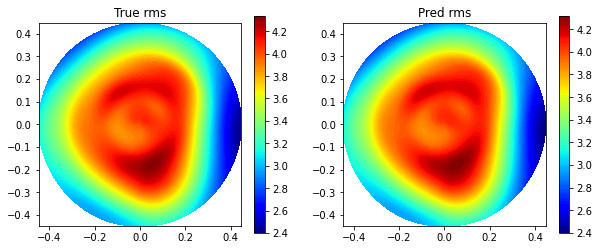

relative error:  0.07417528862588461
MSE:  0.0753332


In [20]:
tempfn_ae = './temp_weights_ae.h5'
model_cb=ModelCheckpoint(tempfn_ae, monitor='loss',save_best_only=True,verbose=0,save_weights_only=True)
cb = [model_cb]

# Training
histae = ae.fit(p_train, p_train,
                epochs=1000,
                batch_size=batch_size,
                shuffle=True,
                callbacks=cb,
                verbose=2
)
loss_ae.extend(histae.history['loss'])
ae.load_weights(tempfn_ae)

plt.figure()
plt.semilogy(loss_ae)
plt.xlabel('epoch')
plt.ylabel('MSE')


pred = ae.predict(p_train).T
pred_rms = np.std(pred,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,pred_rms_interp = read_pressure.interp(pred_rms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('True rms')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,pred_rms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('Pred rms')
plt.colorbar(im1,ax=ax2)

plt.show()

rel_l2 = (np.sum((pred - p_train.T)**2) / np.sum(p_train.T**2))**0.5
error = np.mean((pred - p_train.T)**2)
print('relative error: ', rel_l2)
print('MSE: ', error)